(HW6)=
# HW6

In this task you are suggested to implement gradient descent and Newton's optimization methods, and investigate their performance for three types of functions:

* quadratic function
* loss function of linear regression
* loss function of logistic regression

`BaseSmoothOracle` is an abstract class for objective function $f$ (**oracle**). Each concrete oracle must inherit this class, implementing four methods:

* `func(x)` calculates $f(\boldsymbol x)$
* `grad(x)` calculates $\nabla f(\boldsymbol x)$
* `hess(x)` calculates $\nabla^2 f(\boldsymbol x)$
* `get_opt(x)` calculates point of minimum by direct formula (works only for quadratic and linear regression oracles)

In [21]:
class BaseSmoothOracle(object):
    """
    Base class for implementation of oracles.
    """
    def func(self, x):
        """
        Computes the value of function at point x.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, x):
        """
        Computes the gradient at point x.
        """
        raise NotImplementedError('Grad oracle is not implemented.')
    
    def hess(self, x):
        """
        Computes the Hessian matrix at point x.
        """
        raise NotImplementedError('Hessian oracle is not implemented.')
        
    def get_opt(self):
        """
        Computes the point x at which minimum is attained
        """
        raise NotImplementedError('True solution is unavailable.')

## Quadratic oracle

$$
    f(\boldsymbol x) = \frac 12 \boldsymbol x^\mathsf{T} \boldsymbol{Ax} - \boldsymbol b^\mathsf{T} \boldsymbol x, \quad \boldsymbol A^\mathsf{T}  = \boldsymbol A \in \mathbb R^{n\times n}, \quad \boldsymbol b\in\mathbb R^n
$$

### Task 6.1 (0.5 points)

Let $\boldsymbol A$ be a symmetric positive definite matrix. Solve the optimization task

$$
    \frac 12 \boldsymbol x^\mathsf{T} \boldsymbol{Ax} - \boldsymbol b^\mathsf{T}\boldsymbol x \to \min\limits_{\boldsymbol x \in \mathbb R^n}
$$

analytically.

#### YOUR SOLUTION HERE

To solve the optimization task analytically, we need to find the critical points of the objective function so we compute gradient of f(x) and equal it to 0.

Given the objective function:
$$
f(\boldsymbol x) = \frac{1}{2} \boldsymbol x^\mathsf{T} \boldsymbol{Ax} - \boldsymbol b^\mathsf{T} \boldsymbol x
$$

where $\boldsymbol A$ is a symmetric positive definite matrix.

$$
\nabla f(\boldsymbol x) = \boldsymbol{Ax} - \boldsymbol b = 0
$$

Since $\boldsymbol A$ is symmetric positive definite, it is invertible. Therefore, we can solve for $\boldsymbol x$:
$$
\boldsymbol{Ax} = \boldsymbol b
$$
$$
\boldsymbol x = \boldsymbol A^{-1} \boldsymbol b
$$

Thus, the critical point is at $\boldsymbol x = \boldsymbol A^{-1} \boldsymbol b$.

To determine whether this critical point corresponds to a minimum, maximum, or saddle point, we can use the second derivative test. 

$$ \nabla^2 f(x) = A $$

Since the objective function is convex (because $\boldsymbol A$ is positive definite), any critical point will correspond to a minimum.

Therefore, the solution is $\boldsymbol x = \boldsymbol A^{-1} \boldsymbol b$.

### Task 6.2 (0.5 points)

Implement quadratic oracle {eq}`quadratic-oracle`.

In [22]:
import numpy as np
from scipy.linalg import solve

class QuadraticOracle(BaseSmoothOracle):
    """
    Oracle for quadratic function:
       func(x) = 1/2 x^TAx - b^Tx.
    """

    def __init__(self, A, b):
        if not np.allclose(A, A.T):
            raise ValueError('A should be a symmetric matrix.')
        self.A = A
        self.b = b

    def func(self, x):
        return 0.5 * np.array(x)  @ self.A @ np.array(x) - self.b @ x

    def grad(self, x):
        return np.dot(self.A, x) - self.b

    def hess(self, x):
        return self.A

    def get_opt(self):
        return solve(self.A, self.b)

In [23]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

def plot_levels(func, xrange=None, yrange=None, levels=None):
    """
    Plotting the contour lines of the function.

    Example:
    --------
    >> oracle = QuadraticOracle(np.array([[1.0, 2.0], [2.0, 5.0]]), np.zeros(2))
    >> plot_levels(oracle.func)
    """
    if xrange is None:
        xrange = [-6, 6]
    if yrange is None:
        yrange = [-5, 5]
    if levels is None:
        levels = [0, 0.25, 1, 4, 9, 16, 25]
        
    x = np.linspace(xrange[0], xrange[1], 100)
    y = np.linspace(yrange[0], yrange[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

    CS = plt.contour(X, Y, Z, levels=levels, colors='k')
    plt.clabel(CS, inline=1, fontsize=8) 
    plt.grid()  



## Linear regression oracle


### Task 6.3 (0.5 points)

Implement linear regression oracle

$$
    f(\boldsymbol x) = \frac 1m \Vert \boldsymbol{Ax} - \boldsymbol b\Vert_2^2, \quad \boldsymbol A \in \mathbb R^{m\times n}, \quad \boldsymbol b \in \mathbb R^n
$$

In [24]:
class LinRegOracle(BaseSmoothOracle):
    """
    Oracle for linear regression:
       func(x) = 1/m ||Ax - b||^2.
    """

    def __init__(self, A, b):
        self.A = A
        self.b = b
        self.m = A.shape[0]

    def func(self, x):
        residual = np.dot(self.A, x) - self.b
        return np.linalg.norm(residual) ** 2 / self.m

    def grad(self, x):
        residual = np.dot(self.A, x) - self.b
        return np.dot(self.A.T, residual) / self.m

    def hess(self, x):
        return np.dot(self.A.T, self.A) / self.m
    
    def get_opt(self):
        return np.linalg.lstsq(self.A, self.b, rcond=None)[0]

## Logistic regression oracle

$$
    f(\boldsymbol x) = \frac 1m \sum_{i=1}^m \log\big(1 + \exp(-b_i\boldsymbol a_i^\mathsf{T} \boldsymbol x)\big) + \frac C2\Vert \boldsymbol x\Vert_2^2
$$

### Task 6.4 (0.5 points)

Show that {eq}`log-reg-oracle` is proportional to the loss function of {ref}`binary logistic regression <simple-log-reg>` model with targets denoted as $\pm 1$.

#### YOUR SOLUTION HERE

In logistic regression, the probability of correct classification for a sample $ i $ is given by $ \sigma(y_i \boldsymbol{x}_i^\mathsf{T} \boldsymbol{w}) $, where $ \sigma(z) = \frac{1}{1 + e^{-z}} $ is the sigmoid function. Here, $ y_i $ denotes the target label and $ \boldsymbol{x}_i $ represents the feature vector of sample $ i $.

The logistic regression oracle function is defined as:

$ \text{Oracle}(\boldsymbol{w}) = \frac{1}{m} \sum_{i=1}^{m} \log(1 + e^{-b_i \boldsymbol{w}^\mathsf{T} \boldsymbol{x}_i}) $

where $ \boldsymbol{w} $ is the parameter vector, $ \boldsymbol{x}_i $ are the feature vectors, $ b_i $ are the corresponding target labels, and $ m $ is the number of samples.

In logistic regression, the loss function with regularization is given by:

$ \mathcal{L}(\boldsymbol{w}) = \frac{1}{n} \sum_{i=1}^{n} \log\left(1 + e^{-y_i \boldsymbol{x}_i^\mathsf{T} \boldsymbol{w}}\right) + C \Vert \boldsymbol{w} \Vert_2^2 $

where $ C $ is the regularization parameter, $ \boldsymbol{w} $ is the parameter vector, $ \boldsymbol{x}_i $ are the feature vectors, $ y_i $ are the target labels, $ n $ is the number of samples, and $ \Vert \boldsymbol{w} \Vert_2^2 $ represents the squared $ L_2 $ norm of $ \boldsymbol{w} $.

If we compare two functions

First, we notice that $ y_i $ in the logistic regression loss function corresponds to $ b_i $ in the logistic regression oracle function. This accounts for the correct adjustment of the exponential term based on the target label.

Now, let's consider the regularization term $ C \Vert \boldsymbol{w} \Vert_2^2 $. In logistic regression, this term is added to the loss function to address multicollinearity. However, in the context of proving proportionality, we can simply consider it as an additional constant term.

Thus, by comparing the logistic regression oracle function and the logistic regression loss function, we can conclude that they share the same form, with the only difference being a constant factor added to the loss function.

Therefore, the logistic regression oracle function is indeed proportional to the loss function of the binary logistic regression model with targets denoted as $ \pm 1 $.


### Task 6.5 (1 point)

Find the gradient $\nabla f(\boldsymbol x)$ and hessian $\nabla^2 f(\boldsymbol x)$ of logistic regression oracle {eq}`log-reg-oracle` in matrix-vector form.
The logistic regression oracle function is defined as:

$
f(\boldsymbol{\theta}) = \sum_{i=1}^{N} \log(1 + e^{-y_i \boldsymbol{\theta}^T \mathbf{x}_i})
$

where $ \boldsymbol{\theta} $ is the parameter vector, $ \mathbf{x}_i $ are the feature vectors, and $ y_i $ are the corresponding target labels.

To find the gradient $ \nabla f(\boldsymbol{\theta}) $ and the Hessian $ \nabla^2 f(\boldsymbol{\theta}) $ of this function, let's denote:

- $ \mathbf{X} $ as the matrix of feature vectors, where each row corresponds to a feature vector $ \mathbf{x}_i $.
- $ \mathbf{y} $ as the vector of target labels.
- $ \mathbf{z} $ as the vector $ y_i \boldsymbol{\theta}^T \mathbf{x}_i $.

Then, the logistic regression oracle function can be rewritten using matrix-vector notation as:

$
f(\boldsymbol{\theta}) = \sum_{i=1}^{N} \log(1 + e^{-\mathbf{z}})
$

where $ \mathbf{z} = \mathbf{y} \cdot \mathbf{X} \cdot \boldsymbol{\theta} $.

Now, let's find the gradient $ \nabla f(\boldsymbol{\theta}) $:

$
\nabla f(\boldsymbol{\theta}) = \frac{\partial f}{\partial \boldsymbol{\theta}} = \sum_{i=1}^{N} \frac{\partial}{\partial \boldsymbol{\theta}} \log(1 + e^{-\mathbf{z}})
$

Using the chain rule, we have:

$
\frac{\partial}{\partial \boldsymbol{\theta}} \log(1 + e^{-\mathbf{z}}) = \frac{1}{1 + e^{-\mathbf{z}}} \cdot \frac{\partial}{\partial \boldsymbol{\theta}} (1 + e^{-\mathbf{z}})
$

$
= \frac{1}{1 + e^{-\mathbf{z}}} \cdot e^{-\mathbf{z}} \cdot \frac{\partial}{\partial \boldsymbol{\theta}} (-\mathbf{z})
$

$
= \frac{1}{1 + e^{-\mathbf{z}}} \cdot e^{-\mathbf{z}} \cdot (-\mathbf{y}^T \mathbf{X})
$

$
= -\mathbf{X}^T \cdot \left( \frac{e^{-\mathbf{z}}}{1 + e^{-\mathbf{z}}} \right) \cdot \mathbf{y}
$

$
= -\mathbf{X}^T \cdot \left( \frac{1}{1 + e^{\mathbf{z}}} \right) \cdot \mathbf{y}
$

$
= -\mathbf{X}^T \cdot \boldsymbol{p}
$

where $ \boldsymbol{p} $ is the vector of probabilities defined as $ \boldsymbol{p} = \frac{1}{1 + e^{\mathbf{z}}} $.

Now, let's find the Hessian $ \nabla^2 f(\boldsymbol{\theta}) $:

$
\nabla^2 f(\boldsymbol{\theta}) = \frac{\partial^2 f}{\partial \boldsymbol{\theta}^2}
$

$
= \frac{\partial}{\partial \boldsymbol{\theta}} \left( -\mathbf{X}^T \cdot \boldsymbol{p} \right)
$

$
= -\mathbf{X}^T \cdot \frac{\partial \boldsymbol{p}}{\partial \boldsymbol{\theta}}
$

To find $ \frac{\partial \boldsymbol{p}}{\partial \boldsymbol{\theta}} $, we'll use the chain rule again:

$
\frac{\partial \boldsymbol{p}}{\partial \boldsymbol{\theta}} = \frac{\partial \boldsymbol{p}}{\partial \mathbf{z}} \cdot \frac{\partial \mathbf{z}}{\partial \boldsymbol{\theta}}
$

$
= \frac{\partial}{\partial \mathbf{z}} \left( \frac{1}{1 + e^{\mathbf{z}}} \right) \cdot \frac{\partial}{\partial \boldsymbol{\theta}} (\mathbf{y}^T \mathbf{X} \cdot \boldsymbol{\theta})
$

$
= \left( \frac{e^{\mathbf{z}}}{(1 + e^{\mathbf{z}})^2} \right) \cdot \mathbf{y}^T \mathbf{X}
$

$
= \left( \boldsymbol{p} \circ (1 - \boldsymbol{p}) \right) \cdot \mathbf{y}^T \mathbf{X}
$

where $ \circ $ denotes element-wise multiplication.

So, the Hessian $ \nabla^2 f(\boldsymbol{\theta}) $ is:

$
\nabla^2 f(\boldsymbol{\theta}) = -\mathbf{X}^T \cdot \left( \boldsymbol{p} \circ (1 - \boldsymbol{p}) \right) \cdot \mathbf{X}
$




### Task 6.6 (1 point)

Implement logistic regression oracle {eq}`log-reg-oracle`.

In [15]:
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import log_loss
from scipy.special import expit

class LogRegOracle(BaseSmoothOracle):
    """
    Oracle for logistic regression.
    """

    def __init__(self, A, b, regcoef=1):
        self.A = A
        self.b = b
        self.C = regcoef
        

    def func(self, x):
        y_pred = expit(np.dot(self.A, x))
        loss = log_loss(self.b, y_pred, labels=[-1, 1], sample_weight=None, 
                        eps=1e-15, normalize=True)
        reg_term = 0.5 * self.C * np.linalg.norm(x) ** 2
        return loss + reg_term

    def grad(self, x):
        y_pred = expit(np.dot(self.A, x))
        grad_loss = np.dot(self.A.T, y_pred - self.b) / len(self.b)
        reg_grad = self.C * x
        return grad_loss + reg_grad

    def hess(self, x):
        y_pred = expit(np.dot(self.A, x))
        diag_S = np.diag(y_pred * (1 - y_pred))
        hessian_loss = np.dot(np.dot(self.A.T, diag_S), self.A) / len(self.b)
        reg_hess = self.C * np.eye(len(x))
        return hessian_loss + reg_hess
    
    def get_opt(self):
        """
        Since there is no analytic solution for the optimal weights of logistic regression, 
        we can use any optimization method like sklearn's LogisticRegression
        """
        LR = LogisticRegression(fit_intercept=False, C=1.0/self.C/self.A.shape[0])
        LR.fit(self.A, (self.b + 1) / 2)
        return LR.coef_[0]

## Gradient descent

Given a starting point $\boldsymbol x_0 \in\mathbb R^n$ and learning rate $\eta > 0$, iteratively calculate

$$
    \boldsymbol x_{k+1} = \boldsymbol x_k - \eta \nabla f(\boldsymbol x_k), \quad k = 0, 1,\ldots
$$

The process should stop when either $k = \mathrm{max\_iter}$ or 

$$
\Vert \nabla f(\boldsymbol x_k)\Vert_2^2 \leqslant \varepsilon \Vert \nabla f(\boldsymbol x_0)\Vert_2^2
$$

where $\varepsilon > 0$ is tolerance.

### Task 6.7 (1 point)

Complete the implementation of gradient descent algorithm.

In [16]:
from datetime import datetime
from collections import defaultdict

def gradient_descent(oracle, x_0, learning_rate, tolerance=1e-5, max_iter=10000,
                     trace=False, display=False):
    """
    Gradient descent optimization method.

    Parameters
    ----------
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func(), .grad() and .hess() methods implemented for computing
        function value, its gradient and Hessian respectively.
    x_0 : np.array
        Starting point for optimization algorithm.
    learning_rate : float
        Learning rate.
    tolerance : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.
        Printing format and is up to a student and is not checked in any way.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        "success" or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
                the stopping criterion.
            - 'computational_error': in case of getting Infinity or None value during the computations.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time in seconds passed from the start of the method
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2

    Example:
    --------
    >> oracle = QuadraticOracle(np.eye(5), np.arange(5))
    >> x_opt, message, history = gradient_descent(oracle, np.zeros(5))
    >> print('Found optimal point: {}'.format(x_opt))
       Found optimal point: [ 0.  1.  2.  3.  4.]
    """
    history = defaultdict(list) if trace else None
    x_k = np.copy(x_0)
    grad_at_x_0 = oracle.grad(x_0)

    INF = 1e100
    start_time = datetime.now()

    for i in range(max_iter + 1):     
        grad_at_x_k = oracle.grad(x_k)
        if np.any(np.abs(x_k) > INF) or np.any(np.abs(grad_at_x_k) > INF):
            return x_k, 'computational_error', history

        if trace:
            history['time'].append((datetime.now() - start_time).microseconds * 1e-6)
            history['func'].append(oracle.func(x_k))
            history['grad_norm'].append(np.linalg.norm(grad_at_x_k))
            if x_k.shape[0] <= 2:
                history['x'].append(np.array(x_k))

        if display:
            print("iteration {}: |x_k-x_0| = {}, f(x_k) = {}, |grad(f(x_k))| = {}".format(
                i, np.linalg.norm(x_k - x_0), oracle.func(x_k), np.linalg.norm(grad_at_x_k))
            )

        # YOUR CODE HERE
        if  tolerance * np.linalg.norm(grad_at_x_0)**2 >= np.linalg.norm(grad_at_x_k)**2:
            return x_k, 'success', history

        x_k = x_k - learning_rate * grad_at_x_k.astype(float)

    return x_k, 'iterations_exceeded', history

Now it's try to test gradient descent algorithm on different tasks. Here is some auxiliary code for visualization.

In [17]:
import colorsys

def get_color_array(size):
    HSV_tuples = [(float(i) / size, 1.0, 1.0) for i in range(size)]
    RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    return RGB_tuples

def plot_2d(history, oracle, x_0, x_opt, scale, title, n_levels=3, xlims=None, ylims=None, bound=None, ylim=(None), color="red"):
    import matplotlib.pyplot as plt
    if bound is not None:
        history['x'] = history['x'][:bound]
    hist_x = np.array(history['x']).T
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    
    plt.plot(np.linalg.norm(hist_x - x_opt[:, None], axis=0), c=color, linewidth=3)
    plt.plot(history['grad_norm'], c=color, linewidth=2)
    plt.xlim(0, len(history['grad_norm']) - 1)
    plt.ylim(ylim)
    plt.title(title)
    plt.ylabel('Gradients/residuals norm')
    plt.xlabel('Iteration')
    plt.legend(['Residuals', 'Gradients'])
    plt.grid(ls=":")
    
    plt.subplot(122)
    if xlims is not None:
        x_range = xlims
    else:
        x_range = [x_opt[0] - scale, x_opt[0] + scale]
    if ylims is not None:
        y_range = ylims
    else:
        y_range = [x_opt[1] - scale, x_opt[1] + scale]
    func_opt = oracle.func(x_opt)
    levels = [func_opt + 0.25 * scale / n_levels * i for i in range(1, 4*n_levels + 1, 4)]
    # sizes = np.minimum(5 * float(hist_x.shape[1]) / (np.arange(1, hist_x.shape[1] + 1)), 20)
    plt.scatter(hist_x[0], hist_x[1], s=8, c=get_color_array(hist_x.shape[1]))
    plt.plot(hist_x[0], hist_x[1], alpha=0.6, ls="--", c=color)
    # plt.plot(hist_x[0], hist_x[1], c='r', linewidth=3)
    plt.scatter(x_opt[0], x_opt[1], marker='s', c=color, edgecolors='k')
    plot_levels(oracle.func, xrange=x_range, yrange=y_range, levels=levels)
    plt.title('Trajectory')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(ls=":")
    if xlims is not None:
        plt.xlim(xlims)
    if ylims is not None:
        plt.ylim(ylims)
    plt.show()

def test_2d(method, oracle, x_0, lr, tol=1e-5, scale=1.0, xlims=None, ylims=None, bound=None, ylim=(0, 2), color="red"):
    x_opt = oracle.get_opt()
    if method == 'gd':
        x_star, msg, history = gradient_descent(
            oracle, x_0, lr, tol, trace=True
        )
    elif method == 'newton':
        x_star, msg, history = newton(
            oracle, x_0, lr, tol, trace=True
        )
    else:
        raise ValueError("Unknown error")
    print(msg, len(history['grad_norm']), "iterations")
    plot_2d(history, oracle, x_0, x_opt, scale, 'lr = {}'.format(lr), xlims=xlims, ylims=ylims, bound=bound, ylim=ylim, color="red")



Take a simple quadratic function

$$
    f(x, y) = 2x^2 + 4xy + 5 y^2
$$

which ovbiously has minimum at $(0, 0)$. Now run gradient descent method with $\eta = 0.01$, starting from point $(-2, -1)$:

success 367 iterations


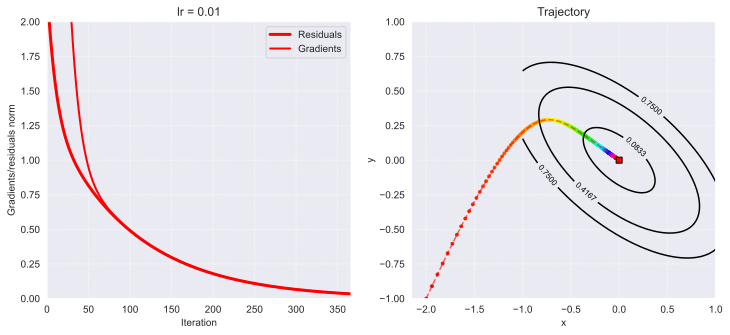

In [18]:
import numpy as np
A = np.array([[2, 2], [2, 5]])
b = np.zeros(2)
q_oracle = QuadraticOracle(A, b)
test_2d("gd", q_oracle, np.array([-2.0, -1.0]), lr=0.01)

If you did all correctly, gradient descent should converge here to optimal point. But this is not always the case:

* if $\eta$ is very small, convergence could be too slow
* if $\eta$ is very big, than gradient descent often diverges

### Task 6.8 (1 point)

Take previous quadratic oracle and try different learning rates and starting points. Find the smallest and the largest learning rates for which gradient descent is still convergent. Provide some characteristic plots. Also, plot a graph of required iterations versus $\eta$.

### GD for linear regression

Let's try it for simple linear regression. Here is a toy example:

success 564 iterations


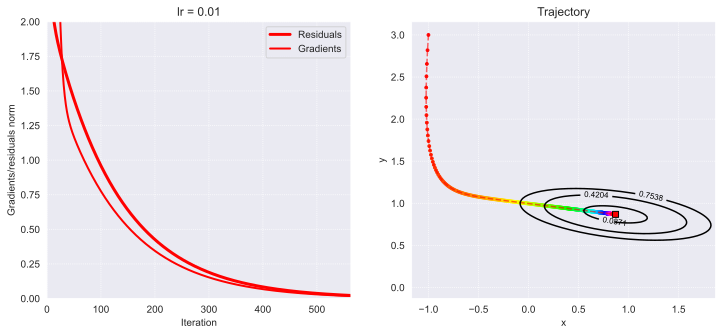

In [19]:
A = np.array([[1, -2.1], [1, 1.2], [1, 4.8]])
b = np.array([-1, 2, 5])
oracle = LinRegOracle(A, b)
test_2d("gd", oracle, np.array([-1, 3.0]), lr=0.01, tol=1e-6)

### Task 6.9 (0.5 points)

Apply gradient descent algorithm to simple linear regression trained on `boston` dataset. Take `lstat` as feature, `medv` as target. Provide some visualizations.

In [20]:
import pandas as pd
import numpy as np

column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = pd.read_csv('"D:\LearningML\Intro2ML\Boston.csv"', header=None, delimiter=r"\s+", names=column_names)
data.head()
A = data['LSTAT'].values.reshape(-1,1)
A = np.hstack([np.ones(A.shape), A])
b= data['MEDV'].values

linreg = LinRegOracle(A,b)
x = np.array([0,0.9])
lrate = 0.001
test_2d('gd', linreg, x, lrate, ylim=(0, 20))

<>:5: SyntaxWarning: invalid escape sequence '\L'
<>:5: SyntaxWarning: invalid escape sequence '\L'
C:\Users\bakit\AppData\Local\Temp\ipykernel_17516\360766075.py:5: SyntaxWarning: invalid escape sequence '\L'
  data = pd.read_csv('"D:\LearningML\Intro2ML\Boston.csv"', header=None, delimiter=r"\s+", names=column_names)


OSError: [Errno 22] Invalid argument: '"D:\\LearningML\\Intro2ML\\Boston.csv"'

### GD for logistic regression

The targets must be from $\{-1, 1\}$. One more toy example:

In [ ]:
x = np.array([[1, -1.6], [0.8, 1.4], [1.5, 6],[2,5]])
y = np.array([-1, 1, 1, -1])

log_oracle = LogRegOracle(x,y)
test_2d("gd", log_oracle, np.array([1, 2.0]), lr=0.001, tol=1e-5)

### Task 6.10 (0.5 points)

Train simple logistic regression model on `breast_cancer` dataset using your gradient descent method. Take any feature from the dataset. Visualize the results.

In [ ]:
from sklearn.datasets import load_breast_cancer
breast = load_breast_cancer()
y = breast['target']
y[y == 0] = -1

# YOUR CODE HERE
i = list(breast.feature_names).index('worst symmetry')
X = breast.data[:, i].reshape(-1, 1)
ones_column = np.ones((X.shape[0], 1))  
X = np.concatenate((ones_column, X), axis=1)

log_oracle = LogRegOracle(X, y)

test_2d("gd", log_oracle, np.array([1, -1.0]), lr=0.001, tol=1e-6)

## Newton's method

Given a starting point $\boldsymbol x_0 \in\mathbb R^n$ and learning rate $\eta > 0$, iteratively calculate

$$
    \boldsymbol x_{k+1} = \boldsymbol x_k - \eta \big(\nabla^2 f(\boldsymbol x_k)\big)^{-1} \nabla f(\boldsymbol x_k), \quad k = 0, 1,\ldots
$$

The process should stop when either $k = \mathrm{max\_iter}$ or 

$$
\Vert \nabla f(\boldsymbol x_k)\Vert_2^2 \leqslant \varepsilon \Vert \nabla f(\boldsymbol x_0)\Vert_2^2
$$

where $\varepsilon > 0$ is tolerance.

### Task 6.11 (1 point)

Complete the implementation of Newton's method.

In [ ]:
import numpy as np
from datetime import datetime
from collections import defaultdict

def newton(oracle, x_0, learning_rate, tolerance=1e-5, max_iter=10000, trace=False, display=False):
    """
    Newton's optimization method.

    Parameters
    ----------
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func(), .grad() and .hess() methods implemented for computing
        function value, its gradient and Hessian respectively. If the Hessian
        returned by the oracle is not positive-definite method stops with message="newton_direction_error"
    x_0 : np.array
        Starting point for optimization algorithm
    learning_rate : float
        Learning rate.
    tolerance : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        'success' or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
                the stopping criterion.
            - 'newton_direction_error': in case of failure of solving linear system with Hessian matrix (e.g. non-invertible matrix).
            - 'computational_error': in case of getting Infinity or None value during the computations.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time passed from the start of the method
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2

    Example:
    --------
    >> oracle = QuadraticOracle(np.eye(5), np.arange(5))
    >> x_opt, message, history = newton(oracle, np.zeros(5), line_search_options={'method': 'Constant', 'c': 1.0})
    >> print('Found optimal point: {}'.format(x_opt))
       Found optimal point: [ 0.  1.  2.  3.  4.]
    """
    history = defaultdict(list) if trace else None
    current_point = np.copy(x_0)
    gradient_at_x_0 = oracle.grad(x_0)

    INF = 1e100
    start_time = datetime.now()

    for i in range(max_iter + 1): 
        gradient_at_current_point = oracle.grad(current_point)
        hessian_at_current_point = oracle.hess(current_point)  

        if np.any(np.abs(current_point) > INF) or np.any(np.abs(gradient_at_current_point) > INF):
            return current_point, 'computational_error', history

        if trace:
            history['time'].append((datetime.now() - start_time).microseconds * 1e-6)
            history['func'].append(oracle.func(current_point))
            history['grad_norm'].append(np.linalg.norm(gradient_at_current_point))
            if current_point.shape[0] <= 2:
                history['x'].append(np.array(current_point))

        if display:
            print("iteration {}: |x_k-x_0| = {}, f(x_k) = {}, |grad(f(x_k))| = {}".format(
                i, np.linalg.norm(current_point - x_0), oracle.func(current_point), np.linalg.norm(gradient_at_current_point))
            )
        try:
            np.linalg.cholesky(hessian_at_current_point)
        except np.linalg.LinAlgError:
            return current_point, 'newton_direction_error', history

        newton_direction = -np.linalg.solve(hessian_at_current_point, gradient_at_current_point)


        current_point = current_point + learning_rate * newton_direction

        if np.linalg.norm(gradient_at_current_point)**2 <= tolerance * np.linalg.norm(gradient_at_x_0)**2:
            return current_point, 'success', history

    return current_point, 'iterations_exceeded', history


### Task 6.12 (1 point)

Apply Newton's methods to the previous tasks:

* quadratic function
* simple linear regression trained on `boston` dataset
* simple logistic regression trained on `breast_cancer` dataset

Compare the number of iterations and time execution of GD and Newton methods in this examples. Visualize your results.

In [ ]:
#Quadratic func

import numpy as np


A = np.array([[2, 2], [2, 5]])
b = np.zeros(2)
q_oracle = QuadraticOracle(A, b)

x_0 = np.array([-2, -1])

x1, m_gd, hist_gd = gradient_descent(q_oracle, x_0, learning_rate=0.004, trace=True)
x2, m_newton, hist_newton = newton(q_oracle, x_0, learning_rate=0.004, max_iter=10000, trace=True)

print('Quadratic func')
print(' Gradient descent iterations number:', len(hist_gd['grad_norm']), "Time:", hist_gd['time'][-1])
print(' Newton iterations number:', len(hist_newton['grad_norm']), "Time:", hist_newton['time'][-1])

plt.figure(figsize=(15, 6))
plt.plot(hist_gd['time'], hist_gd['func'], label='Gradient Descent', marker='o',color='black')
plt.plot(hist_newton['time'], hist_newton['func'], label="Newton's Method", marker='x',color='red')
plt.xlabel('Seconds')
plt.ylabel('Value')
plt.title('Optimization methods Convergence')
plt.legend()
plt.show()




#Simple logistic regression trained on breast_cancer dataset


breast = load_breast_cancer()
y = breast['target']
y[y == 0] = -1
index = list(breast.feature_names).index('worst symmetry')
X = breast.data[:, index].reshape(-1,1)
X = np.hstack([np.ones(X.shape), X])
log_oracle = LogRegOracle(X, y)


x_0 = np.array([-2.0, 1.0])


x1, m_gd, hist_gd = gradient_descent(log_oracle, x_0, learning_rate=0.004, trace=True)
x2, m_newton, hist_newton = newton(log_oracle, x_0, learning_rate=0.004, max_iter=10000, trace=True)

print("logistic regression trained on breast_cancer dataset")
print(' Gradient descent iterations number:', len(hist_gd['grad_norm']), "Time:", hist_gd['time'][-1])
print(' Newton iterations number:', len(hist_newton['grad_norm']), "Time:", hist_newton['time'][-1])

plt.figure(figsize=(15, 6))
plt.plot(hist_gd['time'], hist_gd['func'], label='Gradient Descent', marker='o',color='black')
plt.plot(hist_newton['time'], hist_newton['func'], label="Newton's Method", marker='x',color='red')
plt.xlabel('Seconds')
plt.ylabel('Value')
plt.title('Optimization methods Convergence')
plt.legend()
plt.show()






def load_boston_data():

    column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
    data = pd.read_csv('./housing.csv', header=None, delimiter=r"\s+", names=column_names)
    X = data['LSTAT'].values.reshape(-1,1)
    X = np.hstack([np.ones(X.shape), X])
    y = data['MEDV'].values
    return X,y


X, y = load_boston_data()
linreg = LinRegOracle(X,y)

x_0 = np.array([0,0.8])

x1, m_gd, hist_gd = gradient_descent(linreg, x_0, learning_rate=0.002, trace=True)
x2, m_newton, hist_newton = newton(linreg, x_0, learning_rate=0.002, max_iter=10000, trace=True)
print("Simple linear regression trained on `boston` dataset")
print(' Gradient descent iterations number:', len(hist_gd['grad_norm']), "Time:", hist_gd['time'][-1])
print(' Newton iterations number:', len(hist_newton['grad_norm']), "Time:", hist_newton['time'][-1])

plt.figure(figsize=(15, 6))
plt.plot(hist_gd['time'], hist_gd['func'], label='Gradient Descent', marker='o',color='black')
plt.plot(hist_newton['time'], hist_newton['func'], label="Newton's Method", marker='x',color='red')
plt.xlabel('Seconds')
plt.ylabel('Value')
plt.title('Optimization methods Convergence')
plt.legend()
plt.show()


## GD vs Newton

### Task 6.13 (1 point)

Run both gradient descent and Newton's methods on full `boston` and `breast_cancer` datasets. Do they converge? How many iterations are required for convergence? How much time?

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

def load_boston_data():
    column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
    data = pd.read_csv('./housing.csv', header=None, delimiter=r"\s+", names=column_names)
    features = data.columns.drop('MEDV').tolist()
    X = data[features].values
    y = data['MEDV'].values
    return X, y


def load_breast_cancer_data():
    breast_ds = load_breast_cancer()
    X = breast_ds.data
    y = breast_ds.target
    y[y == 0] = -1
    scaler = StandardScaler()
    scaler.fit(X[:, 1:])
    X[:, 1:] = scaler.transform(X[:, 1:])
    return X, y


def perform_regression_tasks():
    # Load Boston housing dataset
    X_boston, y_boston = load_boston_data()
    
    # Linear Regression
    scaler = StandardScaler()
    scaler.fit(X_boston)
    X_boston_scaled = scaler.transform(X_boston)
    X_boston_scaled = np.hstack([np.ones((X_boston_scaled.shape[0], 1)), X_boston_scaled])
    linreg_oracle = LinRegOracle(X_boston_scaled, y_boston)
    x0_linreg = np.zeros(X_boston_scaled.shape[1])
    opt1_linreg, name1_linreg, history1_linreg = newton(linreg_oracle, x0_linreg, learning_rate=0.03, trace=True)
    opt2_linreg, name2_linreg, history2_linreg = gradient_descent(linreg_oracle, x0_linreg, learning_rate=0.003, trace=True)
    
    # Load and preprocess Breast Cancer dataset
    X_cancer, y_cancer = load_breast_cancer_data()
    

    logreg_oracle = LogRegOracle(X_cancer, y_cancer)
    x0_logreg = np.zeros(X_cancer.shape[1])
    opt1_logreg, name1_logreg, history1_logreg = newton(logreg_oracle, x0_logreg, learning_rate=0.003, trace=True)
    opt2_logreg, name2_logreg, history2_logreg = gradient_descent(logreg_oracle, x0_logreg, learning_rate=0.003, trace=True)
    

    print("Boston dataset:")
    print("Linear Regression - Newton convergence:", name1_linreg, len(history1_linreg['grad_norm']), "iterations, time:", history1_linreg['time'][-1], "seconds")
    print("Linear Regression - Gradient descent convergence:", name2_linreg, len(history2_linreg['grad_norm']), "iterations, time:", history2_linreg['time'][-1], "seconds\n")
    
    print("Breast cancer dataset:")
    print("Logistic Regression - Newton convergence:", name1_logreg, len(history1_logreg['grad_norm']), "iterations, time:", history1_logreg['time'][-1], "seconds")
    print("Logistic Regression - Gradient descent convergence:", name2_logreg, len(history2_logreg['grad_norm']), "iterations, time:", history2_logreg['time'][-1], "seconds")


perform_regression_tasks()